# Time Series Analysis #

## <font color='darkgreen'> Problem Defenition</font>

Finding best solution of segmenting the data by date based on trends in the Value column.  
- Code, 
- Method should be easily repeatable for new data. 
- Output should be a csv file with the following columns StartDate, EndDate, StartValue, EndValue. 

**Start and End Date define the bounds of the segment and we ask you to include the Value (value from the input data) at the start and end of the trend for convenience. **

## <font color='darkgreen'> Algorithm Assumptions</font>
1. **Input structure consists of 2 columns only**: 'Date' & 'Value', based on given input file structure example.

2. **Data Distribution is unknown**, however, **observations are I.I.D**. Since we are using the Pruned Exact Linear Time          **(PELT)**, a dynamic programming change Point algorithm that assumes this (Killick et al, 2012).

3. **Interval min scale is at least 1 day**. Since, we don't want to miss important holidays or other daily events. However, the function allows to set min scale window to another value. 
    
4. **Optimal penalty weight** determined by the following ratio:**$ max  ⁡(\frac{Betwiness Variance}{Withiness Variance})$**. Since, we want to reduce the variance within trends and moreover, increase the variance between them.


## <font color='darkgreen'> Algorithm </font>

In [54]:
# Function definition is here
# Input:
#       path- Input Data Path
#       min_size - minimum days interval for trend (default = 1)
# Output:
#       outputData - Segmented Dataset 
#       optChangePoints - Array of best change points represened by input's row indices
def timeSeriesTrendAnalysis(path, min_size=1):
    
    
    ############################################### Importing Packages ###############################################
    # $pip3 install ruptures#
    import pandas as pd
    import ruptures as rpt
    import statistics as stat
    import datetime as dt
    
    ########################################### Data Loading & Preparation ###########################################
    
    #Load Data
    Data= pd.read_csv(path)

    #Casting Date Column to datetime
    Data['Date'] = pd.to_datetime(Data['Date']) 

    #Sort Data by Dates (Ascending)
    Data=Data.sort_values(by='Date')

    # Reindexing Data
    Data.index=range(0,len(Data))

    ######################################## Performing Timeseries Trend Analysis ####################################

    
    # Variables Initialization
    withinessVar,betwinessVar,optRatio,optPenalty=0,0,0,0
    Data['Interval']=""

    # Using Change point detection algorithm (using ruptures package)
    model = "l1"  # "l2", 
    algo = rpt.Pelt(model=model, min_size=min_size).fit(Data['Value'])

    #Finding best penalty value [0.2,4]
    for penalty in np.arange(0.2, 4.0, 0.2):    
        my_bkps = algo.predict(pen=penalty)
        counter,dInd,mbInd=0,0,0

        # Assigning each observation to Trend Interval Number
        while dInd<len(Data) :
            UB=my_bkps[mbInd]
            if dInd>UB:
                counter+=1
                mbInd+=1
            Data.set_value(dInd, 'Interval', counter)
            dInd+=1

        #Calculating Between Groups variance to Within Groups variance Ratio
        totalWithinVar=Data.groupby('Interval').Value.agg('var').sum()
        totalBetweenVar=Data.groupby('Interval').Value.agg('sum').var()
        ratio=totalBetweenVar/totalWithinVar

        # Want to Maximize Between Groups variance to Within Groups variance Ratio 
        if(ratio>optRatio):
            optRatio=ratio
            optPenalty=penalty
            optChangePoints=my_bkps
            
    ################################################# Output Creation ################################################


    # Creating Output Data Frame
    outputData=pd.DataFrame(columns=['StartDate', 'EndDate', 'StartValue', 'EndValue'])
    
    # Setting 1st row
    outputData.loc[0]=[dt.date.strftime(Data.iloc[0]['Date'], "%Y-%m-%d"),
                       Data.iloc[optChangePoints[0]]['Date'],
                       Data.iloc[0]['Value'],
                       Data.iloc[optChangePoints[0]]['Value']]
    
    # Setting other rows except last row
    for outInd in range(0,len(optChangePoints)-2) : 
        outputData.loc[outInd+1] = [dt.date.strftime((Data.iloc[optChangePoints[outInd]]['Date']
                                     + dt.timedelta(days=1)), "%Y-%m-%d"),
                                 Data.iloc[optChangePoints[outInd+1]]['Date'],
                                 Data.iloc[optChangePoints[outInd]]['Value'],
                                 Data.iloc[optChangePoints[outInd+1]]['Value']]

    # Setting last row
    outputData.loc[len(outputData)]=[dt.date.strftime((Data.iloc[optChangePoints[len(optChangePoints)-2]]['Date']
                                     + dt.timedelta(days=1)), "%Y-%m-%d"),
                                     Data.iloc[len(Data)-1]['Date'],
                                     Data.iloc[optChangePoints[len(optChangePoints)-2]]['Value'],
                                     Data.iloc[len(Data)-1]['Value']]


    #Save CSV Output
    outputData.to_csv((path.split('.')[0]+'_Output.csv'), sep='\t',index=False, encoding='utf-8')

    return outputData,optChangePoints;


**Importing Packages**

In [13]:
import numpy as np
import pandas as pd
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import ruptures as rpt
import statistics as stat
import datetime as dt

**Data Loading & Preparation**

In [57]:
#Load Data
path="TrendData.csv"
Data= pd.read_csv(path)

#Casting Date Column to datetime
Data['Date'] = pd.to_datetime(Data['Date']) 

#Sort Data by Dates (Ascending)
Data=Data.sort_values(by='Date')

# Reindexing Data
Data.index=range(0,len(Data))

**Input Top 5 Rows**

In [55]:
#Viewing Input
Data.head()

,Date,Value
0,1999-01-10,106967.0
1,1999-01-11,105345.0
2,1999-01-12,100932.0
3,1999-02-11,105283.0
4,1999-02-12,100746.0


### Performing Trend Analysis to a Time Series Input ###

In [53]:
# Perform PELT change point detection on timeseries input
output,OptCP=timeSeriesTrendAnalysis("TrendData.csv",1)

### Time series outputs segmentations Visualization ### 

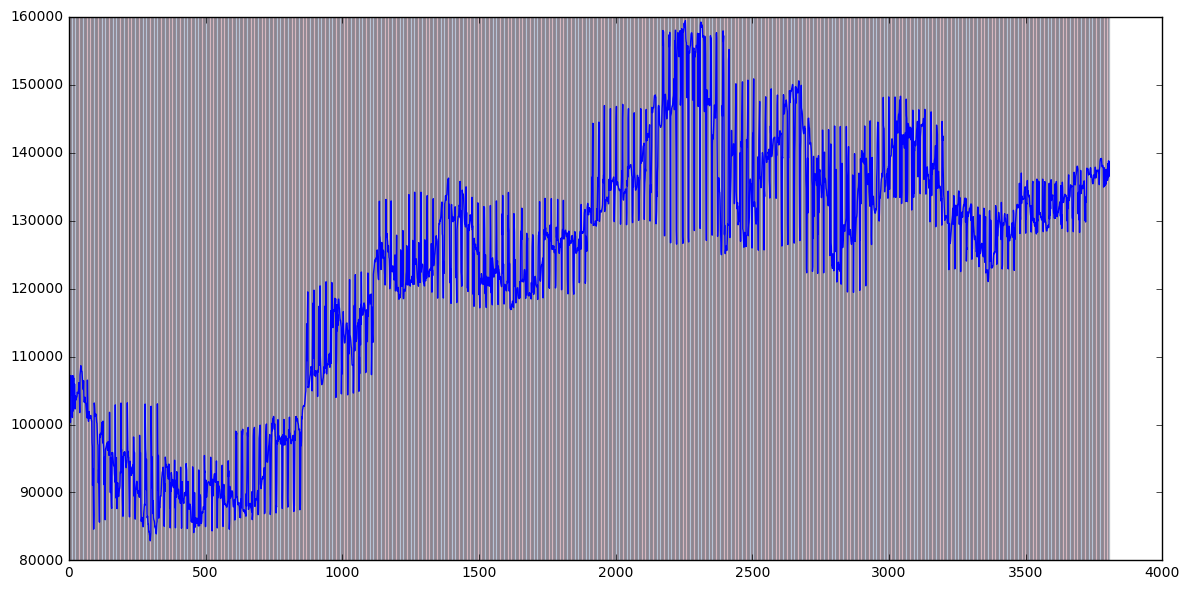

In [50]:
## # show results (segments) on input data
fig=rpt.show.display(Data['Value'],OptCP,figsize=(12, 6))
plt.show() 

**Output Top 5 Rows**

In [51]:
output.head()

,StartDate,EndDate,StartValue,EndValue
0,1999-01-10,1999-03-11,106967.0,105068.0
1,1999-03-12,1999-05-11,105068.0,104293.0
2,1999-05-12,1999-07-10,104293.0,107195.0
3,1999-07-11,1999-08-12,107195.0,102416.0
4,1999-08-13,1999-09-14,102416.0,103646.0


## <font color='darkgreen'> Algorithm Future Improvments</font> 

Other information that could be helpful in choosing my approach is:

-	**Known Data Distribution** - Using more specific models like exponential smoothing, Brown, Seasonality etc.

-	**Known Minimal/Maximal/Constant Time interval scale** - Could reduce search complexity time and use faster            
     approaches then Dynamic Programming.

-	**Known Trend's number** 
   Could also reduce search complexity time and to use simpler approaches.


## <font color='darkgreen'> References </font>


R. Killick, P. Fearnhead & I. A. Eckley (2012) Optimal Detection of Changepoints With a Linear Computational Cost, Journal of the American Statistical Association, 107:500, 1590-1598, DOI: 10.1080/01621459.2012.737745